In [1]:
# Copyright 2020 Fabian Hofmann
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# (2) Evaluation of C-VGAN

In this notebook, the evaluation of C-VGAN is done. Note C-VGAN in its original form is exclusively about video generation (and reconstruction for the input frames), so this evaluation excludes any anomaly detection evaluation - this is done in the respective IFTM evaluation with the best models built and evaluated here (and in the [other notebook](https://gitlab.tubit.tu-berlin.de/sulandir/Thesis/blob/master/src/eval/cvgan_1_eval.ipynb) of C-VGAN evaluation). In addition, only the conditional generative models using 3D latent input are evaluated and not the models that either use no predefined input or merely a single frame, because the latter ones are not relevant to IFTM using C-VGAN.

The models evaluated here are built in the same way as in the first scripts and they are evaluated based on their hyperparameters. However, due to the time required to train a model fully (>48 hours), a classical grid search or other optimization of the hyperparameters is difficult if not unfeasible without the necessary computation resources. Therefore we base most of our parameters on the the original VGAN paper by Vondrick et al. [1](http://www.cs.columbia.edu/~vondrick/tinyvideo/), and hard-code the different parameters we want to evaluate for the model directly (there is no point in iterating over the different permutations of the hyperparameters, if running the entire evaluation would take weeks if not months). The notebook is also designed to be shut down and continued at a later point in time using checkpoints due to the long running time.

##### Sources
- [Our implementation of C-VGAN](https://gitlab.tubit.tu-berlin.de/sulandir/Thesis/blob/master/src/models/vgan_conditional_3d_2.ipynb)
- [The preset VGAN models and their streams](https://gitlab.tubit.tu-berlin.de/sulandir/Thesis/blob/master/src/models/vgan.py)

## Setup

In [2]:
import tensorflow as tf

tf.__version__

'2.5.0-dev20201111'

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
import math
import numpy as np
import os
import time

from src.io_.batch_generator import UniformBatchGenerator, BatchLoader
from src.io_.gif_writer import write_gif_grid
from src.models.vgan import *

In [5]:
base_input_path = "../../data/upCam/preprocessed_128_64/"
base_output_path = "../../output/evaluation/vgan/vgan_conditional_3d_2/"

### Init batch generator for training/validation/testing

As in the original C-VGAN with 3d input notebook [1](https://gitlab.tubit.tu-berlin.de/sulandir/Thesis/blob/master/src/models/vgan_conditional_3d_2.ipynb) the generator gets the first 7 frames as input and it has to generate an 8th frame for it. The discriminator gets the actual ~1.5 second (8 frames) video and learns to distinguish the actual from the fake/generated video clips.

The [dataset](https://gitlab.tubit.tu-berlin.de/sulandir/thesis_data) consists of 10 days (days "00-04" and "05-09" collected in sets). For evaluation, the dataset is split -- 60% is used for training, 20% for validation during training and 20% for testing.

Note that the batch size for validation and testing set is meaningless -- it merely serves as a (minor) speedup and has no influence on the actual losses.

In [6]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256]
BATCH_SIZE = batch_sizes[4]

In [7]:
days_training = ["00", "01", "02", "05", "06", "07"]
day_paths_training = [base_input_path + day + "/" for day in days_training]
training_generator = UniformBatchGenerator(day_paths=day_paths_training, batch_size=BATCH_SIZE, sample_size=8, subsample_size=7)

In [8]:
days_validation = ["03", "08"]
day_paths_validation = [base_input_path + day + "/" for day in days_validation]
validation_generator = UniformBatchGenerator(day_paths=day_paths_validation, batch_size=256, sample_size=8, subsample_size=7)

In [9]:
days_testing = ["04", "09"]
day_paths_testing = [base_input_path + day + "/" for day in days_testing]
testing_generator = UniformBatchGenerator(day_paths=day_paths_testing, batch_size=256, sample_size=8, subsample_size=7)

## C-VGAN Models

C-VGAN models are built and trained just like in [vgan_conditional_3d_2.ipynb](https://gitlab.tubit.tu-berlin.de/sulandir/Thesis/blob/master/src/models/vgan_conditional_3d_2.ipynb).

### Model init

In [10]:
def make_generator_model() -> keras.Model:
    inputs: tf.Tensor = keras.Input(shape=(7, 64, 128, 3))

    e_3d = make_encoder_foreground_stream(inputs)
    f, m = make_conditional_foreground_stream(e_3d)

    e_2d = make_encoder_background_stream(inputs)
    b = make_conditional_background_stream(e_2d)

    outputs = make_generator_stream_combiner(f, m, b)

    return keras.Model(inputs=inputs, outputs=outputs, name="c_vgan_generator")

In [11]:
c_vgan_generator = make_generator_model()
c_vgan_generator.summary()

Model: "c_vgan_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 64, 128,  0                                            
__________________________________________________________________________________________________
conv3d_5 (Conv3D)               (None, 4, 32, 64, 64 5184        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 7, 32, 64, 64 5184        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_9 (ReLU)                  (None, 4, 32, 64, 64 0           conv3d_5[0][0]                   
___________________________________________________________________________________

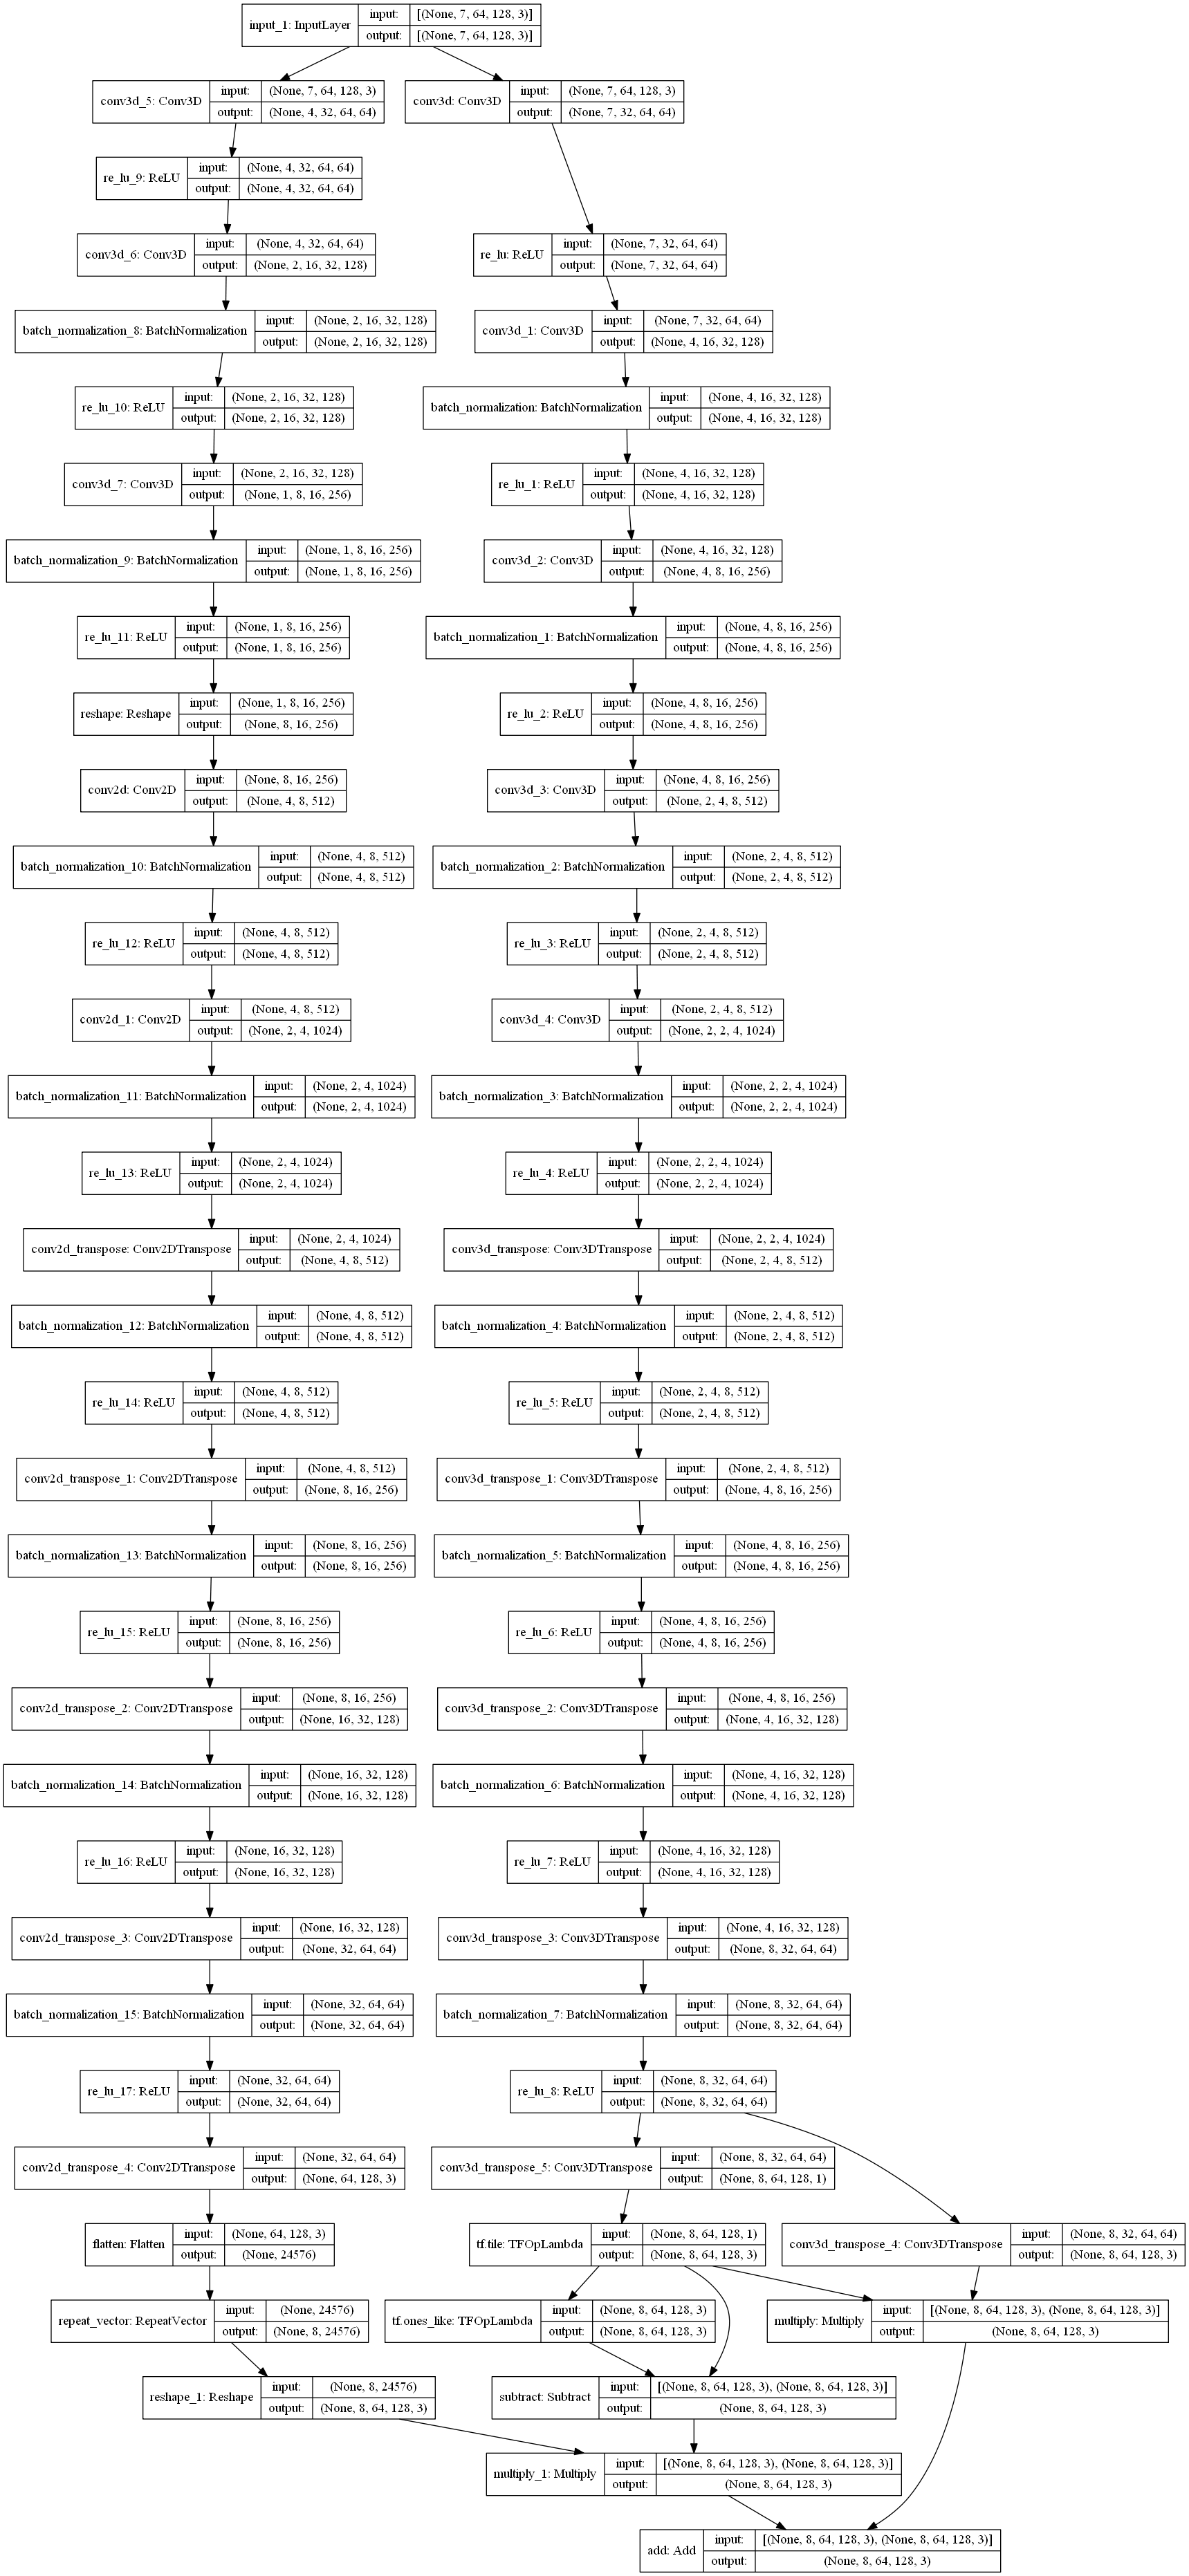

In [12]:
keras.utils.plot_model(c_vgan_generator, base_output_path + "img/c_vgan_generator.png", show_shapes=True)

The discriminator usually overpowers the generator (failure mode) because of the properties of the data (it is too easy to distinguish real from fake ones. Therefore, two ways to impair the discriminator can be used; a reduction/increase in the number of filters on each convolutional layers (default `32`, multiplied by 2,4 , etc. for later layers respectively) and dropout layers that are applied to each convolutional layer (default rate `0`).

In [13]:
filters = [8, 16, 32, 64]
FILTER = filters[2]

dropout_rates = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
DROPOUT_RATE = dropout_rates[0]

c_vgan_discriminator = make_discriminator_model(FILTER, DROPOUT_RATE)
c_vgan_discriminator.summary()

Model: "vgan_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 64, 128, 3)]   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 8, 32, 64, 32)     2592      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 32, 64, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 16, 32, 64)     55296     
_________________________________________________________________
batch_normalization_16 (Batc (None, 4, 16, 32, 64)     256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 16, 32, 64)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 4, 8, 16, 12

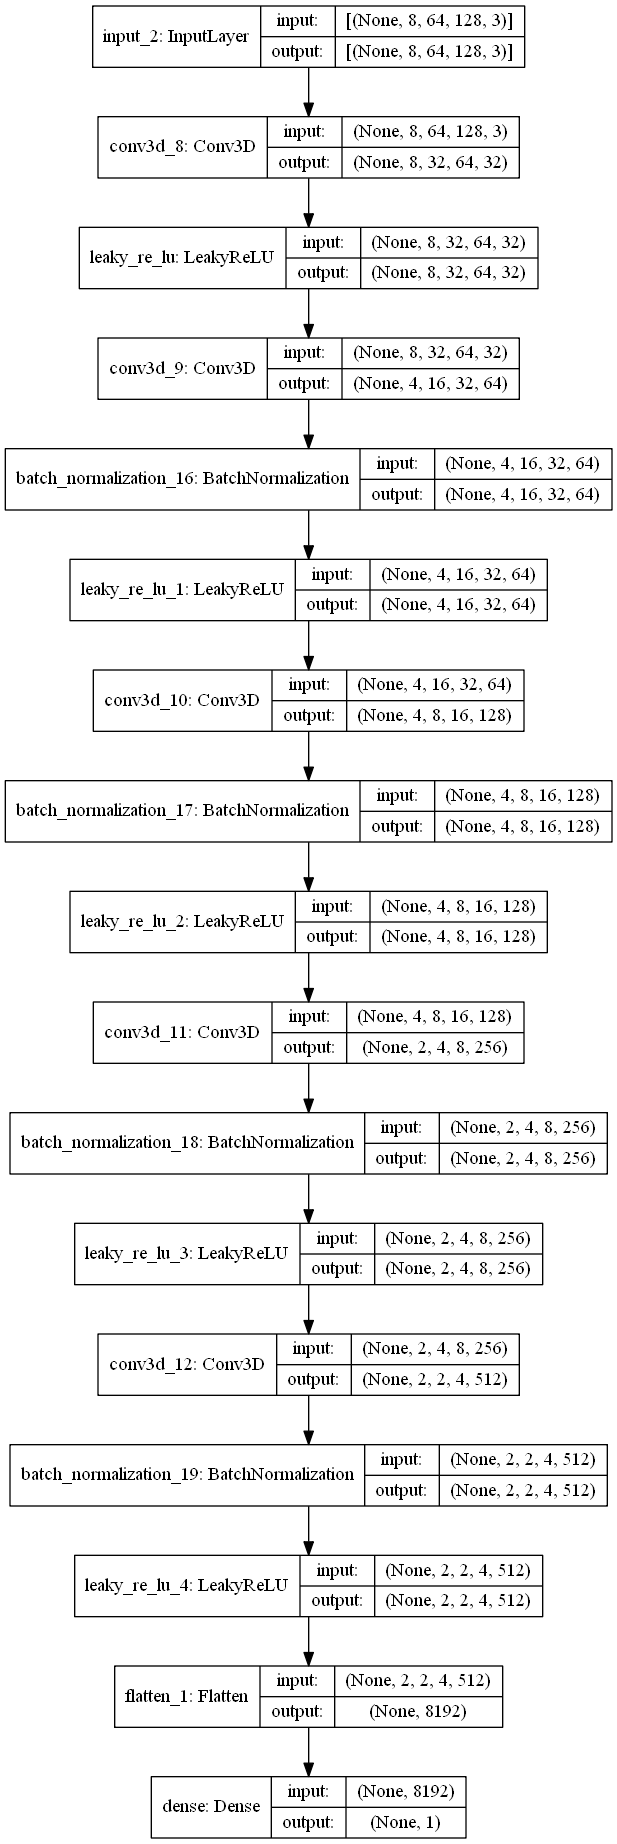

In [14]:
keras.utils.plot_model(c_vgan_discriminator, base_output_path + "img/c_vgan_discriminator.png", show_shapes=True)

### Loss and optimizers init

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_abs_err = tf.keras.losses.MeanAbsoluteError()

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

Lambda for is kept to its original value from the paper, because it can only be evaluated through IFTM and not through validator (and test) losses, because it influences the quality of the 8th frame prediction and weights the input to the pure generational output (a smaller lambda increases the degrees of freedom for the generator, while keeping the scenes for the discriminator realistic, but in return the scenes will less resemble the conditional input (from which to interpolate the 8th frame).

In [17]:
lambdas = [5, 8, 10, 14, 20]
LAMBDA = lambdas[2]

In [ ]:
def generator_loss(fake_output, input_videos, generated_videos):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    reconstruction_loss = mean_abs_err(input_videos, generated_videos[:,:7]) * LAMBDA
    return fake_loss + reconstruction_loss

When adjusting `BATCH_SIZE`, one also has to change the original learning rate by a factor [\[1\]](https://arxiv.org/abs/1404.5997). The momentum term (`beta_1`) is kept the same however. Note that because ADAM is used as an optimizer, the learning rate is adapted either way.

In [18]:
learning_rates_mult = [0.5, 1, 2, 4]
LEARNING_RATE = math.sqrt(learning_rates_mult[1]) * 2e-4

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5)

## Set up separate outputs for configs

Logs, graphs, and checkpoints for different parameter permutations are stored in separate files and directories to make the handling of the different configs easier later.

In [20]:
OUTPUT_PREFIX = "cvgan_2_dfilter-{}_ddropout-{}_lambda-{}_batchsize-{}_learningrate-{}".format(FILTER, DROPOUT_RATE, LAMBDA, BATCH_SIZE, LEARNING_RATE)

## Handle checkpoints

In [21]:
checkpoint_dir = base_output_path + "training_checkpoints/" + OUTPUT_PREFIX + "/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=c_vgan_generator,
                                 discriminator=c_vgan_discriminator)

Load the latest checkpoint (if available). This is crucial in case one wants to run longer training sessions that are unfeasible as a continuous run.

In [22]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest_checkpoint)
if latest_checkpoint:
    print("Restored from {}".format(latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ../../output/evaluation/vgan/vgan_conditional_3d_2/training_checkpoints/cvgan_2_dfilter-32_ddropout-0.0_lambda-10_batchsize-64_learningrate-0.0002/ckpt-4


## Handle Logfiles

For the (csv) log files, during training the results are appended to the existing ones - this further allows the continuous evaluation of a parameter setting across a multitude of epochs.

In [23]:
LOG_FILE = base_output_path + OUTPUT_PREFIX + ".csv"

try:
    file = open(LOG_FILE, 'r')
    print("Existing log file found, evaluation results will be appended to it.")
except IOError:
    file = open(LOG_FILE, 'w')
    print("Initializing new log file.")
    file.write("g_train_loss;d_train_loss;g_val_loss;d_val_loss\n")
file.close()

Existing log file found, evaluation results will be appended to it.


### Define the training loop

Nothing is changed regarding the kind of training and optimization of the gradients, however a `test_step` was added to evaluate the validator loss between epoch (and the test loss after full training).

In [24]:
@tf.function
def train_step(batch):
    input_videos, real_videos = batch

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_videos = c_vgan_generator(input_videos, training=True)

        real_output = c_vgan_discriminator(real_videos, training=True)
        fake_output = c_vgan_discriminator(generated_videos, training=True)

        gen_loss = generator_loss(fake_output, input_videos, generated_videos)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, c_vgan_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, c_vgan_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, c_vgan_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, c_vgan_discriminator.trainable_variables))

    return gen_loss, disc_loss

In [25]:
def test_step(batch):
    input_videos, real_videos = batch

    generated_videos = c_vgan_generator(input_videos, training=False)

    real_output = c_vgan_discriminator(real_videos, training=False)
    fake_output = c_vgan_discriminator(generated_videos, training=False)

    gen_loss = generator_loss(fake_output, input_videos, generated_videos)
    disc_loss = discriminator_loss(real_output, fake_output)

    return gen_loss, disc_loss

Every training iteration, the overall loss for generator and discriminator is computed (both training and validation) and then output along with the total time for training of the epoch. The function below is used for both training, validation, and testing.

In [26]:
def exec_epoch(batch_generator: UniformBatchGenerator, step_fn: Callable):
    g_loss = keras.metrics.Mean()
    d_loss = keras.metrics.Mean()

    batch_loader = BatchLoader(batch_generator, 2048 // batch_generator.batch_size, no_workers=4)
    for _ in range(len(batch_loader)):
        batch = batch_loader.get_batch()
        g_batch_loss, d_batch_loss = step_fn(batch)
        g_loss.update_state(g_batch_loss)
        d_loss.update_state(d_batch_loss)
    batch_loader.shutdown_workers()

    return g_loss.result().numpy(), d_loss.result().numpy()

In [27]:
def train(epochs, start_epoch=0):
    for epoch in range(start_epoch, epochs):
        # train
        start = time.time()
        g_train_loss, d_train_loss = exec_epoch(training_generator, train_step)
        stop = time.time()

        # validate
        g_val_loss, d_val_loss = exec_epoch(validation_generator, test_step)

        # Create checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generate some example videos for visual help
        generate_and_save_videos(c_vgan_generator, epoch + 1, examples_input)

        # Append metrics to log file
        log = open(LOG_FILE, 'a')
        # noinspection PyTypeChecker
        np.savetxt(log, [[g_train_loss, d_train_loss, g_val_loss, d_val_loss]], fmt="%.8f", delimiter=";")
        log.close()

        print("Epoch {}: Training Time - {:.2f} sec, g_train_loss - {:.8f}, d_train_loss - {:.8f}, g_val_loss - {:.8f}, d_val_loss - {:.8f},".format(epoch + 1, stop - start, g_train_loss, d_train_loss, g_val_loss, d_val_loss))

## Generate and save videos

For monitor the training progress, we generate 16 test videos each epoch as a sanity check whether the generator still produces a variety of videos (this is done beside the train and validation loss metrics); video inputs are taken from the first batch of the test batch.

In [28]:
examples_input = testing_generator[0][0][::16]
examples_output = testing_generator[0][1][::16]

In [29]:
anim_file_dir = base_output_path + "anim/" + OUTPUT_PREFIX + "/"

if not os.path.exists(anim_file_dir):
    os.makedirs(anim_file_dir)

In [30]:
test_anim_grid = base_output_path + "anim/" + "test_anim.gif"
write_gif_grid(test_anim_grid, examples_output, fps=5, dpi=600)

In [31]:
def generate_and_save_videos(model, epoch, test_input):
    predictions = model(test_input, training=False).numpy()

    anim_grid = anim_file_dir + "anim_at_epoch_{:04d}.gif".format(epoch)
    write_gif_grid(anim_grid, predictions, fps=5, dpi=600)

## Train the model

If one continues from a checkpoint, `start_epoch` should be set to the checkpoint's epoch (`=0` for no checkpoint). Will only influence logs inside the notebook and file names for any files being generated; loss logs will be appended as normal.

In [32]:
train(epochs=50, start_epoch=40)

Epoch 41: Training Time - 1495.76 sec, g_train_loss - 6.19283009, d_train_loss - 0.17568049, g_val_loss - 2.43492723, d_val_loss - 1.38289499,
Epoch 42: Training Time - 1524.72 sec, g_train_loss - 6.09882402, d_train_loss - 0.16878864, g_val_loss - 3.11990476, d_val_loss - 2.23505282,
Epoch 43: Training Time - 1484.86 sec, g_train_loss - 6.08227444, d_train_loss - 0.18306603, g_val_loss - 3.45752454, d_val_loss - 1.61872983,
Epoch 44: Training Time - 1430.08 sec, g_train_loss - 6.16278028, d_train_loss - 0.17396238, g_val_loss - 4.17557907, d_val_loss - 2.37713861,
Epoch 45: Training Time - 1428.18 sec, g_train_loss - 5.98023844, d_train_loss - 0.18012330, g_val_loss - 2.97678399, d_val_loss - 1.62654519,
Epoch 46: Training Time - 1427.75 sec, g_train_loss - 6.03092813, d_train_loss - 0.17177160, g_val_loss - 4.18071127, d_val_loss - 2.04423356,
Epoch 47: Training Time - 1427.66 sec, g_train_loss - 5.89576197, d_train_loss - 0.18635288, g_val_loss - 2.44977498, d_val_loss - 1.50185537,

## Test the model

Run over the entire test set and compute both generator and discriminator test loss.

In [33]:
print(exec_epoch(testing_generator, test_step))

(1.841029, 2.2588778)
